# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px # подключаем графическую библиотеку plotly
from IPython.display import display #импортируем метод дисплей для красивого вывода таблиц (не применяя print)
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) #выводим значения float до 3 знаков после запятой
from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.preprocessing import OrdinalEncoder # порядковое кодирование
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Если хочешь сделать ещё лучше, соблюдай стандарт PEP-8, раздели на группы и в каждой группе отсортируй импорты в алфовитном порядке.
Ссылка для ознакомления: https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html 

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000


Предварительный вывод информации о данных показал следующее:

1. Имеется ряд столбцов, которые не влияют не цену автомобиля, а именно: DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen, NumberOfPictures. Месяц регистрации по своему типу похож на год регистрации, но при покупке цена практически не зависит от данного параметра. Т.к. эти столбцы не влияют на цену, то они не включаются в модель и не требуют серьезного исследовательского анализа данных. В следующих пунктах речь пойдет только об оставшихся столбцах.
2. Замечен ряд признаков с пропусками данных, а именно в столбцы: VehicleType, Gearbox, Model, FuelType, NotRepaired. Далее значения в этих столбцах будут рассмотрены подробнее и будет принято решение об их удалении или каком-либо заполнении.
3. Имеются нулевые цены на автомобили и выбросы, которые значительно смещают среднее арифмитическое.
4. Имеются нереальные годы регистрации как снизу так и сверху.
5. Имеются автомобили с нулевой и очень большой мощностью.

По пунктам 3-5 также требуется провести дополнительный исследовательский анализ данных.



### Удалим лишние столбцы, которые не входят в признаки, чтобы не выводить лишние данные по датасету каждый раз.

In [5]:
not_features = ['RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures']
df = df.drop(not_features, axis=1)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Заполнение пропусков

#### Обработка пропусков в типах кузовов и моделях.

In [6]:
df['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Наравне с нормальными типами кузовов, имеются как пропуски, так и просто кузов под названием other. Посмотрим сколько пропусков в типе кузова и как заполнены другие данные для таких строк.

In [7]:
df[df['VehicleType'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37490 entries, 0 to 354365
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DateCrawled       37490 non-null  object
 1   Price             37490 non-null  int64 
 2   VehicleType       0 non-null      object
 3   RegistrationYear  37490 non-null  int64 
 4   Gearbox           27520 non-null  object
 5   Power             37490 non-null  int64 
 6   Model             30662 non-null  object
 7   Kilometer         37490 non-null  int64 
 8   FuelType          20195 non-null  object
 9   Brand             37490 non-null  object
 10  NotRepaired       16919 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.4+ MB


Логично предположить, что пропуски в типах кузова можно заполнить исходя из модели автомобиля. При этом всего для 30662 объектов указана модель, значит только для них можно выявить тип кузова на основе схожих данных, а остальные данные можно заменить на значение other.

In [8]:
df['Model'] = df['Model'].fillna('other')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       354369 non-null  object
 1   Price             354369 non-null  int64 
 2   VehicleType       316879 non-null  object
 3   RegistrationYear  354369 non-null  int64 
 4   Gearbox           334536 non-null  object
 5   Power             354369 non-null  int64 
 6   Model             354369 non-null  object
 7   Kilometer         354369 non-null  int64 
 8   FuelType          321474 non-null  object
 9   Brand             354369 non-null  object
 10  NotRepaired       283215 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


In [10]:
df['VehicleType'] = df['VehicleType'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       354369 non-null  object
 1   Price             354369 non-null  int64 
 2   VehicleType       354369 non-null  object
 3   RegistrationYear  354369 non-null  int64 
 4   Gearbox           334536 non-null  object
 5   Power             354369 non-null  int64 
 6   Model             354369 non-null  object
 7   Kilometer         354369 non-null  int64 
 8   FuelType          321474 non-null  object
 9   Brand             354369 non-null  object
 10  NotRepaired       283215 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


#### Заполнение пропусков в коробке передач

Можно предположить, что у каждой модели автомобилей имеется неравное распределение количества выпущенных экземпляров на ручной или автоматической коробке передач. Посмотрим несколько примеров распределения.

In [11]:
df['Gearbox'].value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

Согласно общему количеству больше всего авто на ручной коробке передач, посмотрим несколько примеров.

In [12]:
df.groupby(['Model', 'Gearbox'])['Gearbox'].count().head(30)

Model    Gearbox
100      auto          63
         manual       336
145      manual        40
147      auto          29
         manual       520
156      auto          45
         manual       556
159      auto          26
         manual       183
1_reihe  auto          72
         manual      1171
1er      auto         422
         manual      3022
200      auto           4
         manual        12
2_reihe  auto         151
         manual      4521
300c     auto         139
         manual         1
3_reihe  auto         227
         manual      3164
3er      auto        3780
         manual     15306
4_reihe  auto         106
         manual       507
500      auto          43
         manual       835
5_reihe  auto          42
         manual       386
5er      auto        4261
Name: Gearbox, dtype: int64

Произведем заполнение пропусков значением "other".

In [13]:
df['Gearbox'] = df['Gearbox'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       354369 non-null  object
 1   Price             354369 non-null  int64 
 2   VehicleType       354369 non-null  object
 3   RegistrationYear  354369 non-null  int64 
 4   Gearbox           354369 non-null  object
 5   Power             354369 non-null  int64 
 6   Model             354369 non-null  object
 7   Kilometer         354369 non-null  int64 
 8   FuelType          321474 non-null  object
 9   Brand             354369 non-null  object
 10  NotRepaired       283215 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


#### Заполнение пропусков для типа топлива

Аналогично коробке произведем заполнение пропусков для типа топлива.

In [14]:
df['FuelType'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [15]:
df['FuelType'] = df['FuelType'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       354369 non-null  object
 1   Price             354369 non-null  int64 
 2   VehicleType       354369 non-null  object
 3   RegistrationYear  354369 non-null  int64 
 4   Gearbox           354369 non-null  object
 5   Power             354369 non-null  int64 
 6   Model             354369 non-null  object
 7   Kilometer         354369 non-null  int64 
 8   FuelType          354369 non-null  object
 9   Brand             354369 non-null  object
 10  NotRepaired       283215 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


#### Заполнение пропусков в данных о ремонте

In [16]:
df['NotRepaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

Исходя из соотношения классов видим, что неремонтируемых автомобилей в 4 раза больше, чем ремонтируемых. Пропуски в данных скорей всего обусловлены тем, что люди при добавлении объявления на сайт пропускали эту графу, обозначая это, что модель не был в ремонте. В виду данных 2-х фактов наиболее логичным представляется заполнить пропуски значениями no.

In [17]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [18]:
df['NotRepaired'].value_counts(dropna=False)

no     318315
yes     36054
Name: NotRepaired, dtype: int64

### Обработка аномальных значений в целевом столбце

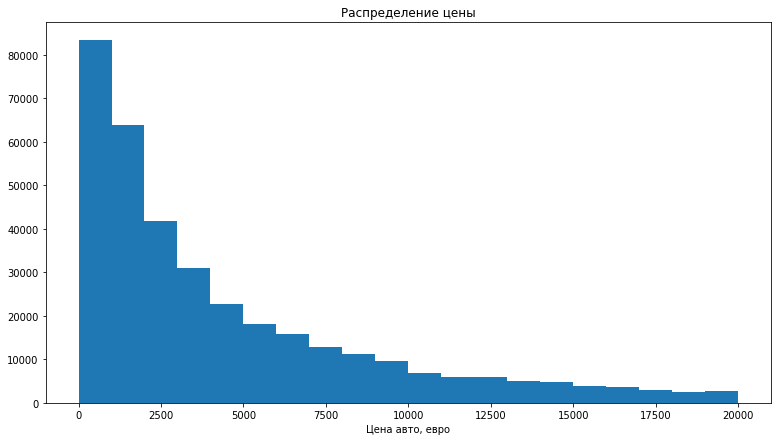

In [19]:
plt.figure(figsize=(13,7))
plt.hist(df['Price'], bins=20)
plt.title("Распределение цены")
plt.xlabel("Цена авто, евро")
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

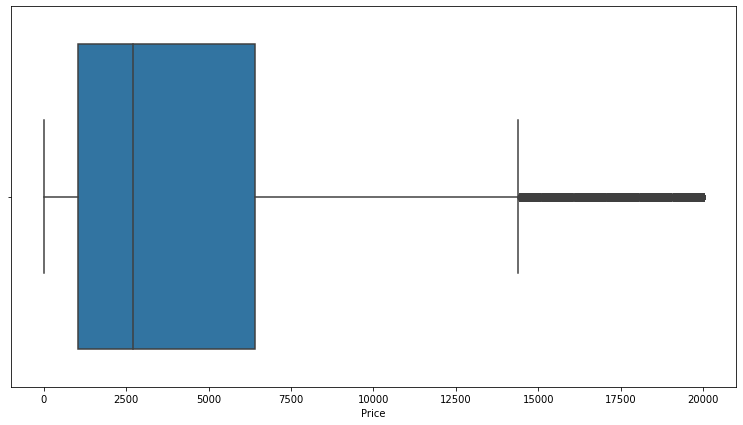

In [20]:
plt.figure(figsize=(13,7))
sns.boxplot(df['Price'])

На графиках можно отетливо увидеть Пуссоновское распределение. Граница правого уса заканчивается на 14525 тысячах евро, далее идут более дорогие машины. Необходимо посмотреть примеры таких машин и определиться являются ли их цены ошибками или они действительно так стоят. Также достаточно большое количество машин стоимостью от 0 до 500 евро. По ним также посмотрим данные более подробнее.

In [21]:
df[df['Price'] < 50]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,2016-03-26 22:06:17,0,other,1990,other,0,corsa,150000,petrol,opel,no
59,2016-03-29 15:48:15,1,suv,1994,manual,286,other,150000,other,sonstige_autos,no
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
111,2016-03-19 18:40:12,0,other,2017,manual,0,golf,5000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,other,2000,manual,65,corsa,150000,other,opel,yes
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,petrol,ford,no
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,petrol,suzuki,no
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [22]:
df[df['Price'] == 0]['NotRepaired'].value_counts()

no     8767
yes    2005
Name: NotRepaired, dtype: int64

In [23]:
df[df['Price'] < 50]['NotRepaired'].value_counts()

no     10130
yes     2293
Name: NotRepaired, dtype: int64

Из анализа приведенных данных по низким ценам можно сделать следующие выводы (предположения):

1. По большей части до 50 евро продаются битые машины.
2. Очень большое количество данных, где цена авто = 0. Возможно люди просто хотят избавиться от старого ненужного авто, но возможно, что это ошибка заполнения данных. В связи с тем, что невозможно установить истину относительно таких значений, то авто с 0-й ценой лучше исключить из датасета.
3. Если предположить, что машина битая, то она может продаваться за такую цену, но целая машина точно не может стоить меньше хотя бы 100 евро. Поэтому небитые машины с ценой менее 100 евро также должны быть исключены из датасета.

Посмотрим на другой конец распределения - очень дорогие машины.

In [24]:
df[df['Price'] > 15000].head(30)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
14,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no
33,2016-03-25 21:48:47,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no
172,2016-03-07 12:38:19,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no
179,2016-03-08 20:58:31,16449,wagon,2015,auto,110,fabia,10000,petrol,skoda,no
204,2016-03-31 12:58:26,18400,wagon,2011,auto,313,5er,150000,gasoline,bmw,no
236,2016-03-05 17:50:33,15700,sedan,2011,manual,170,golf,90000,gasoline,volkswagen,no
282,2016-03-06 12:38:13,18700,coupe,2009,auto,213,mustang,80000,petrol,ford,no
287,2016-03-19 16:40:33,16150,suv,2011,manual,150,tiguan,30000,petrol,volkswagen,no
313,2016-03-05 19:47:47,16500,coupe,2007,manual,265,z_reihe,150000,petrol,bmw,no


Выведенные данные показали, что в диапазон цен свыше 15000 попали машины действительно дорогого сегмента, поэтому удаление выбросов с этой стороны не требуется.

In [25]:
df = df[df['Price'] != 0]
df = df.drop(df[(df['Price'] < 100) & (df['NotRepaired'] != 'no')].index)

Обработка аномалий по цене выполнена.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343040 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       343040 non-null  object
 1   Price             343040 non-null  int64 
 2   VehicleType       343040 non-null  object
 3   RegistrationYear  343040 non-null  int64 
 4   Gearbox           343040 non-null  object
 5   Power             343040 non-null  int64 
 6   Model             343040 non-null  object
 7   Kilometer         343040 non-null  int64 
 8   FuelType          343040 non-null  object
 9   Brand             343040 non-null  object
 10  NotRepaired       343040 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.4+ MB


#### Удалим выбросы в колонке RegistrationYear

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RegistrationYear'>

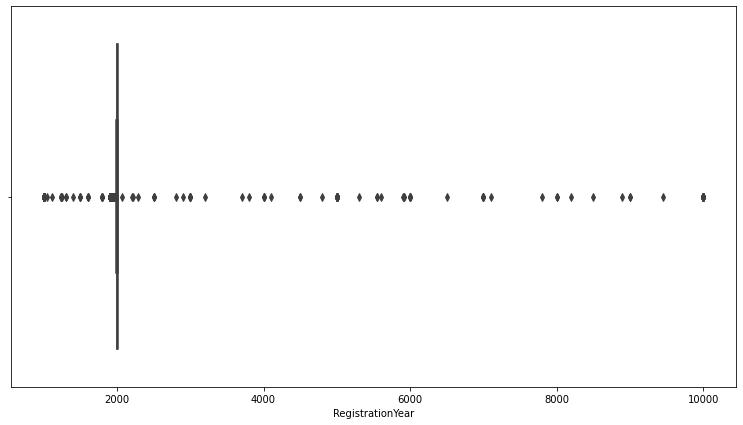

In [27]:
plt.figure(figsize=(13,7))
sns.boxplot(df['RegistrationYear'])

In [28]:
print(df['DateCrawled'].max())
print(df['DateCrawled'].min())

2016-04-07 14:36:58
2016-03-05 14:06:22


In [29]:
print(df['RegistrationYear'].max())
print(df['RegistrationYear'].min())

9999
1000


Учитывая то, что данные были выгружены в период с 2016-04-07 по 2016-03-05, в DF не могут пресутствовать машины занегистрированные позднее.
Дополнительно отметим, что выбросами также можно считать автомобили с регистрацией ранее 1980 года.

Удалим выбросы.

In [30]:
df = df[df['RegistrationYear'] < 2017]
df = df[df['RegistrationYear'] > 1980]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325626 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       325626 non-null  object
 1   Price             325626 non-null  int64 
 2   VehicleType       325626 non-null  object
 3   RegistrationYear  325626 non-null  int64 
 4   Gearbox           325626 non-null  object
 5   Power             325626 non-null  int64 
 6   Model             325626 non-null  object
 7   Kilometer         325626 non-null  int64 
 8   FuelType          325626 non-null  object
 9   Brand             325626 non-null  object
 10  NotRepaired       325626 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.8+ MB


In [31]:
print(df['RegistrationYear'].max())

2016


In [32]:
df = df.drop('DateCrawled', axis=1)

#### Удалим выбросы в колонке Power

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Power'>

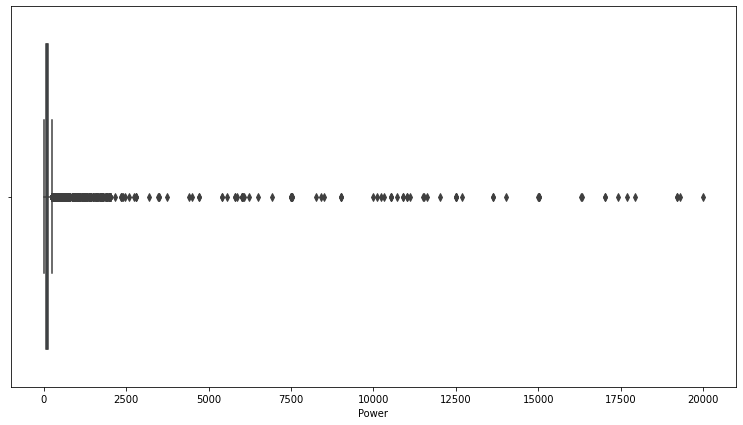

In [33]:
plt.figure(figsize=(13,7))
sns.boxplot(df['Power'])

Выбросами являются обьявления с мощностью свыше 250 л.с.
Удалим их.

In [34]:
df = df[df['Power'] < 250]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317981 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             317981 non-null  int64 
 1   VehicleType       317981 non-null  object
 2   RegistrationYear  317981 non-null  int64 
 3   Gearbox           317981 non-null  object
 4   Power             317981 non-null  int64 
 5   Model             317981 non-null  object
 6   Kilometer         317981 non-null  int64 
 7   FuelType          317981 non-null  object
 8   Brand             317981 non-null  object
 9   NotRepaired       317981 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.7+ MB


### Проверка на дубликаты

Проверим наш датасет на наличие полных дубликатов и при их нахождении избавимся от них.

In [35]:
df.duplicated().sum() # проверим на дубликаты

48072

Зафиксировано большое количество дубликатов, что говорит о том, что продается значительное количество похожих автомобилей. Уберем дубликаты, чтобы не переобучать модели.

In [36]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269909 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             269909 non-null  int64 
 1   VehicleType       269909 non-null  object
 2   RegistrationYear  269909 non-null  int64 
 3   Gearbox           269909 non-null  object
 4   Power             269909 non-null  int64 
 5   Model             269909 non-null  object
 6   Kilometer         269909 non-null  int64 
 7   FuelType          269909 non-null  object
 8   Brand             269909 non-null  object
 9   NotRepaired       269909 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.7+ MB


### Проверка на мультиколлинеарность

Проверим корреляцию наших признаков между собой.

<AxesSubplot:>

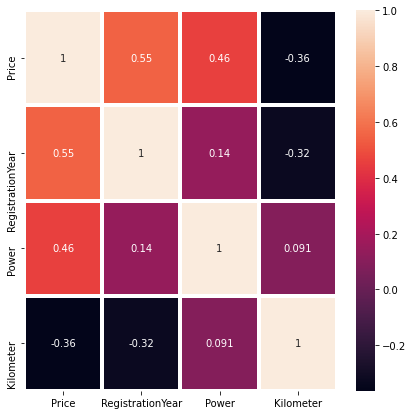

In [37]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
sns.heatmap(df.corr(), annot=True, linewidths=3, linecolor='white')

Цена незначительно зависит от года регистрации и мощности авто, обучающие признаки не коррелируют друг с другом, следовательно удаления признаков не требуется.

### Подготовка датасета для обучения различных моделей

Проведем кодирование категориальных признаков. В дальнейшем будем использовать различные модели, в зависимости от модели необходимо применять различные типы кодирования. В случае линейной регрессии подойдет техника прямого кодирования (англ. One-Hot Encoding, OHE), а в случае деревьев и лесов - порядкового кодирования (ordinal encoding), поэтому далее будет подготовлено два набора данных для обоих видов кодирования. После кодирования необходимо будет сделать масштабирование числовых признаков. Также в случае ряда бустинговых моделей кодировка не требуется, поэтому будет подготовлен 3-й датасет без кодировки, но с масштабированием.

In [38]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
# кодирование OHE
df_ohe = pd.get_dummies(df, drop_first=True, columns=cat_columns)
display(df_ohe.head(10))

# кодирование OE
encoder = OrdinalEncoder()
df_ord = df.copy()
df_ord[cat_columns] = encoder.fit_transform(df_ord[cat_columns])
display(df_ord.head(10))

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_other,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
0,480,1993,0,150000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,3.000,1993,1.000,0,116.000,150000,6.000,38.000,0.000
1,18300,2.000,2011,1.000,190,166.000,125000,2.000,1.000,1.000
2,9800,6.000,2004,0.000,163,117.000,125000,2.000,14.000,0.000
3,1500,5.000,2001,1.000,75,116.000,150000,6.000,38.000,0.000
4,3600,5.000,2008,1.000,69,101.000,90000,2.000,31.000,0.000
5,650,4.000,1995,1.000,102,11.000,150000,6.000,2.000,1.000
6,2200,1.000,2004,1.000,109,8.000,150000,6.000,25.000,0.000
8,14500,0.000,2014,1.000,125,60.000,30000,6.000,10.000,0.000
9,999,5.000,1998,1.000,101,116.000,150000,5.000,38.000,0.000
10,2000,4.000,2004,1.000,105,10.000,150000,6.000,19.000,0.000


In [39]:
# функция для деления датасетов на обучающую, и тестовую выборки
def split_func (df):
    target = df['Price']
    features = df.drop('Price', axis=1)
    
    features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345) # разделили выборки в пропорции 2 к 8
    
    
    return features_train, features_test, target_train, target_test

In [40]:
# получим выборки для кодировки OHE
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = split_func(df_ohe)

In [41]:
# проверим полученные размерности
for i in [features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe]:
    print(i.shape)

(215927, 304)
(53982, 304)
(215927,)
(53982,)


In [42]:
# получим выборки для кодировки ord
features_train_ord, features_test_ord, target_train_ord, target_test_ord = split_func(df_ord)

# проверим полученные размерности
for i in [features_train_ord, features_test_ord, target_train_ord, target_test_ord]:
    print(i.shape)

(215927, 9)
(53982, 9)
(215927,)
(53982,)


In [43]:
# получим выборки без кодировки
features_train_no, features_test_no, target_train_no, target_test_no = split_func(df)

# проверим полученные размерности
for i in [features_train_no, features_test_no, target_train_no, target_test_no]:
    print(i.shape)

(215927, 9)
(53982, 9)
(215927,)
(53982,)


Проведем масштабирование признаков во всех выборках.

In [44]:
# подготовим функцию для масштабирования
def scal_func (features_train, features_test):
    numeric = ['RegistrationYear', 'Power', 'Kilometer']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_test

In [45]:
# масштабируем данные с кодировкой ohe
features_train_ohe, features_test_ohe = scal_func (features_train_ohe, features_test_ohe)
features_train_ohe.describe() # проверим результат масштабирования

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_other,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
count,215927.000,215927.000,215927.000,215927.000,215927.000,215927.000,215927.000,215927.000,215927.000,215927.000,215927.00

In [46]:
# масштабируем данные с кодировкой ord
features_train_ord, features_test_ord = scal_func (features_train_ord, features_test_ord)

In [47]:
# масштабируем данные с кодировкой no
features_train_no, features_test_no = scal_func (features_train_no, features_test_no)

**ВЫВОД по 1 части**

На этапе подготовки данных проведена следующая работа:

1. Исключены столбцы, не являющиеся обучающими признаками (DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen, NumberOfPictures).
2. Проведено заполнение пропусков значением other для: типа кузова, типа коробки передач, типа топлива, состояния ремонта.
3. Исключены нулевые цены, а также цены до 100 евро на небитые автомобили.
4. Проведено удаление дубликатов.
5. Проведена проверка на мультиколлинеарность.
6. Датасет разделен на обучающие, валидационные и тестовые выборки для трех кодировок: one-hot encoding, ordinal encoding, без кодировки.
7. Проведено масштабирование количественных данных.

## Обучение моделей

Обучим следующие модели: линейная регрессия, решающее дерево, случайный лес, CatBoost, LightGBM.

### Линейная регрессия

Произведем определение оптимальных параметров для линейной регрессии с помощью функционала GridSearchCV.

In [48]:
# создадим функцию для необходимого скора
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

In [49]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)
grid.fit(features_train_ohe, target_train_ohe)
print("RMSE линейной регрессии составляет ", grid.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............fit_intercept=True, normalize=True; total time=  30.6s
[CV 2/5] END .............fit_intercept=True, normalize=True; total time=  25.4s
[CV 3/5] END .............fit_intercept=True, normalize=True; total time=  24.5s
[CV 4/5] END .............fit_intercept=True, normalize=True; total time=  22.4s
[CV 5/5] END .............fit_intercept=True, normalize=True; total time=  23.1s
[CV 1/5] END ............fit_intercept=True, normalize=False; total time=  21.8s
[CV 2/5] END ............fit_intercept=True, normalize=False; total time=  22.9s
[CV 3/5] END ............fit_intercept=True, normalize=False; total time=  21.9s
[CV 4/5] END ............fit_intercept=True, normalize=False; total time=  24.2s
[CV 5/5] END ............fit_intercept=True, normalize=False; total time=  23.5s
[CV 1/5] END ............fit_intercept=False, normalize=True; total time=  21.0s
[CV 2/5] END ............fit_intercept=False, nor

In [50]:
print('Наилучшие подобранные параметры для линейной регрессии')
grid.best_params_

Наилучшие подобранные параметры для линейной регрессии


{'fit_intercept': True, 'normalize': False}

Наилучший RMSE 3241.883 при GridSearchCV получен для параметров: 'fit_intercept': True, 'normalize': False.


### Решающее дерево

In [51]:
tree = DecisionTreeRegressor(random_state=12345)
    
tree_params = {'max_depth': range(1,15),
              'min_samples_split': range(2,7)}

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, verbose=5, scoring=scorer)

tree_grid.fit(features_train_ord, target_train_ord)

print("RMSE для решающего дерева составляет ", tree_grid.best_score_)


print('Наилучшие подобранные параметры для решающего дерева')
print(tree_grid.best_params_)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END ...............max_depth=1, min_samples_split=2; total time=   0.2s
[CV 2/5] END ...............max_depth=1, min_samples_split=2; total time=   0.1s
[CV 3/5] END ...............max_depth=1, min_samples_split=2; total time=   0.1s
[CV 4/5] END ...............max_depth=1, min_samples_split=2; total time=   0.1s
[CV 5/5] END ...............max_depth=1, min_samples_split=2; total time=   0.0s
[CV 1/5] END ...............max_depth=1, min_samples_split=3; total time=   0.2s
[CV 2/5] END ...............max_depth=1, min_samples_split=3; total time=   0.0s
[CV 3/5] END ...............max_depth=1, min_samples_split=3; total time=   0.1s
[CV 4/5] END ...............max_depth=1, min_samples_split=3; total time=   0.1s
[CV 5/5] END ...............max_depth=1, min_samples_split=3; total time=   0.1s
[CV 1/5] END ...............max_depth=1, min_samples_split=4; total time=   0.1s
[CV 2/5] END ...............max_depth=1, min_sa

Наилучший RMSE 2027.922 при GridSearchCV получен для параметров: 'max_depth': 14, 'min_samples_split': 6.

### Случайный лес

In [52]:
forest = RandomForestRegressor(random_state=12345)
    
forest_params = {'n_estimators': range(30, 81, 10),
                 'max_depth': range(1,12)}

forest_grid = GridSearchCV(forest, forest_params,
                         cv=5, verbose=5, scoring=scorer)

forest_grid.fit(features_train_ord, target_train_ord)

print("RMSE для случайного леса составляет ", forest_grid.best_score_)


print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
[CV 1/5] END ...................max_depth=1, n_estimators=30; total time=   1.7s
[CV 2/5] END ...................max_depth=1, n_estimators=30; total time=   1.7s
[CV 3/5] END ...................max_depth=1, n_estimators=30; total time=   1.7s
[CV 4/5] END ...................max_depth=1, n_estimators=30; total time=   1.6s
[CV 5/5] END ...................max_depth=1, n_estimators=30; total time=   1.7s
[CV 1/5] END ...................max_depth=1, n_estimators=40; total time=   2.2s
[CV 2/5] END ...................max_depth=1, n_estimators=40; total time=   2.3s
[CV 3/5] END ...................max_depth=1, n_estimators=40; total time=   2.2s
[CV 4/5] END ...................max_depth=1, n_estimators=40; total time=   2.3s
[CV 5/5] END ...................max_depth=1, n_estimators=40; total time=   2.3s
[CV 1/5] END ...................max_depth=1, n_estimators=50; total time=   2.8s
[CV 2/5] END ...................max_depth=1, n_

Наилучший RMSE 1939.527 при GridSearchCV для случайного леса получен для параметров: 'max_depth': 11, 'n_estimators': 70.

### Light GBM

Т.к. одна из подзадач данного проекта - это самостоятельное изучение библиотеки Light GBM, сделаем небольшой конспект по ее особенностям.

Light GBM - это быстрая, распределенная, высокопроизводительная структура повышения градиента, основанная на алгоритме дерева решений, используемая для ранжирования, классификации и многих других задач машинного обучения.

Поскольку он основан на алгоритмах дерева решений, он разделяет лист дерева с наилучшим соответствием, тогда как другие алгоритмы повышения делят дерево по глубине или уровню, а не по листу. Таким образом, при выращивании на одном и том же листе в Light GBM, листовой алгоритм может уменьшить больше потерь, чем поуровневый алгоритм, и, следовательно, приводит к гораздо лучшей точности, что редко может быть достигнуто любым из существующих алгоритмов повышения.

Преимущества:

1. Быстрая скорость обучения и высокая эффективность: использует алгоритм на основе гистограммы, то есть он объединяет непрерывные значения признаков в дискретные ячейки, которые ускоряют процедуру обучения.
2. Более низкое использование памяти: заменяет непрерывные значения на дискретные ячейки, что приводит к снижению использования памяти.
3. Лучшая точность, чем у любого другого алгоритма усиления: создает гораздо более сложные деревья, следуя подходу с разбивкой по листам, а не по уровням, что является основным фактором в достижении более высокой точности.
4. Совместимость с большими наборами данных: способен одинаково хорошо работать с большими наборами данных при значительном сокращении времени обучения по сравнению с XGBOOST.

Важные параметры:

* n_estimators - количество деревьев для бустинга;
* max_depth - глубина деревьев, по умолчанию используется неопредёленное значение, поскольку механизм по умолчанию для управления сложностью деревьев заключается в использовании конечного количества узлов;
* num_leaves: количество узлов. Наличие большого количества листьев улучшит точность, но также приведет к переообучению.
* max_bin: максимальное количество ячеек, в которых хранятся значения признаков. Меньше max_bin уменьшает переообучение.
* lambda_l1, а также lambda_l2: контролирует регуляризацию L1 и L2.
* learning_rate: скорость обучения.

Несмотря на то, что библиотеки Light GBM и CatBoost не требуют кодирования нечисловых признаков, такие признаки рекомендуется перевести в тип category.

In [53]:
def obj_to_cat (df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')

In [54]:
obj_to_cat(features_train_no)
features_train_no.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215927 entries, 346281 to 277827
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       215927 non-null  category
 1   RegistrationYear  215927 non-null  float64 
 2   Gearbox           215927 non-null  category
 3   Power             215927 non-null  float64 
 4   Model             215927 non-null  category
 5   Kilometer         215927 non-null  float64 
 6   FuelType          215927 non-null  category
 7   Brand             215927 non-null  category
 8   NotRepaired       215927 non-null  category
dtypes: category(6), float64(3)
memory usage: 8.0 MB


In [55]:
obj_to_cat(features_test_no)
features_test_no.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53982 entries, 227067 to 171656
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       53982 non-null  category
 1   RegistrationYear  53982 non-null  float64 
 2   Gearbox           53982 non-null  category
 3   Power             53982 non-null  float64 
 4   Model             53982 non-null  category
 5   Kilometer         53982 non-null  float64 
 6   FuelType          53982 non-null  category
 7   Brand             53982 non-null  category
 8   NotRepaired       53982 non-null  category
dtypes: category(6), float64(3)
memory usage: 2.0 MB


Попробуем подобрать наиболее оптимальные параметры.

In [56]:
cat_feat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

gbm = LGBMRegressor(random_state=12345)
    
g_params = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}

g_grid = GridSearchCV(gbm, g_params,
                         cv=5, verbose=5, scoring=scorer)

g_grid.fit(features_train_no, target_train_no)

print("RMSE для LGBM составляет ", g_grid.best_score_)


print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50, num_leaves=21; total time=   2.1s
[CV 2/5] END learning_rate=0.01, n_estimators=50, num_leaves=21; total time=   2.1s
[CV 3/5] END learning_rate=0.01, n_estimators=50, num_leaves=21; total time=   2.1s
[CV 4/5] END learning_rate=0.01, n_estimators=50, num_leaves=21; total time=   2.2s
[CV 5/5] END learning_rate=0.01, n_estimators=50, num_leaves=21; total time=   2.2s
[CV 1/5] END learning_rate=0.01, n_estimators=50, num_leaves=31; total time=   3.5s
[CV 2/5] END learning_rate=0.01, n_estimators=50, num_leaves=31; total time=   2.5s
[CV 3/5] END learning_rate=0.01, n_estimators=50, num_leaves=31; total time=   2.5s
[CV 4/5] END learning_rate=0.01, n_estimators=50, num_leaves=31; total time=   2.5s
[CV 5/5] END learning_rate=0.01, n_estimators=50, num_leaves=31; total time=   2.5s
[CV 1/5] END learning_rate=0.01, n_estimators=50, num_leaves=41; total time=   3.0s
[CV 2/5] END l

Наилучший RMSE 1684.875 при GridSearchCV для LGBM получен для параметров: 'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41.

### CatBoost

Проведем также поиск оптимальных параметров для CatBoostRegressor.

In [57]:
cbr = CatBoostRegressor(cat_features = cat_feat, loss_function="RMSE")

grid = {'learning_rate': [0.03, 0.1, 0.5],
        'iterations': [150, 500]}

cbr_grid = GridSearchCV(cbr, grid,
                         cv=5, verbose=5, scoring=scorer)

cbr_grid.fit(features_train_no, target_train_no)

print("RMSE для CBR составляет ", cbr_grid.best_score_)


print('Наилучшие подобранные параметры для CBR')
print(cbr_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 4373.6217550	total: 121ms	remaining: 18.1s
1:	learn: 4290.7637091	total: 182ms	remaining: 13.4s
2:	learn: 4209.2519489	total: 249ms	remaining: 12.2s
3:	learn: 4131.8564840	total: 313ms	remaining: 11.4s
4:	learn: 4055.2567363	total: 380ms	remaining: 11s
5:	learn: 3981.2610437	total: 432ms	remaining: 10.4s
6:	learn: 3909.4612468	total: 485ms	remaining: 9.9s
7:	learn: 3839.5409487	total: 536ms	remaining: 9.52s
8:	learn: 3773.7875253	total: 586ms	remaining: 9.18s
9:	learn: 3709.0012139	total: 639ms	remaining: 8.94s
10:	learn: 3645.9622593	total: 689ms	remaining: 8.71s
11:	learn: 3585.7376304	total: 740ms	remaining: 8.51s
12:	learn: 3528.0012563	total: 790ms	remaining: 8.32s
13:	learn: 3470.9133389	total: 842ms	remaining: 8.18s
14:	learn: 3416.7122719	total: 892ms	remaining: 8.03s
15:	learn: 3363.7101665	total: 944ms	remaining: 7.91s
16:	learn: 3313.2772368	total: 996ms	remaining: 7.79s
17:	learn: 3263.4466899	total: 1.05

Наилучший RMSE 1724.287 при GridSearchCV для CBR получен для параметров: 'iterations': 500, 'learning_rate': 0.5. И опять метрика чуть хуже.

**ВЫВОД по 2 части**

Обучено и подобраны гиперпараметры для 5 различных моделей: линейная регрессия, решающее дерево, случайный лес, CatBoost, LightGBM. Для всех моделей была применена кросс-валидация, вшитая в метод GridSearchCV.

Наихудшим результатом (2805 евро) обладает модель линейной регрессии, наилучший результат был получен с помощью модели Light GBM (1673 евро), сравнительно недалеко от него находится результат модели CatBoostRegressor (1710 евро). Исходя из этого, можно заключить, что бустинговые модели лучше справились с минимизацией поставленной метрики. В следующем разделе каждая модель с найденными гиперпараметрами будет обучена на трейне и протестирована на тестовой выборке.

## Анализ моделей

In [58]:
# создадим таблицу для хранения результатов
d = {'model': [], 'RMSE':[], 'fit_time': [], 'predict_time':[]}
results = pd.DataFrame(data=d)
results

,model,RMSE,fit_time,predict_time


In [59]:
# создадим функцию для добавления результатов в таблицу
def model_res(model_name, model, features_train, target_train):
    rmse, fit_time, pred_time = ml(model, features_train, target_train)
    results.loc[len(results)] = [model_name, rmse, fit_time, pred_time]
    if len(results) > 0: # исключим дублировании при неоднократном выполнении функции для одной и той же модели
        results.drop_duplicates(inplace=True)

In [60]:
# cоздадим функцию для расчета необходимых параметров
def ml (model, features_train, target_train):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    
    stop_fit_time = time.time()
    
    fit_time = stop_fit_time - start_fit_time
    
    start_predict_time = time.time()
    rmse = cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error')
    rmse = np.mean(list(map(lambda x: x * (-1), rmse)))**0.5

#     predictions = model.predict(features_test)
    stop_predict_time = time.time()
    
    pred_time = stop_predict_time - start_predict_time
    
#     rmse = mean_squared_error(target_test, predictions)**0.5
    
    return rmse, fit_time, pred_time

In [61]:
# линейная регрессия
lr = LinearRegression(fit_intercept=True, normalize=False)
model_res('LinearRegression', lr,  features_train_ohe, target_train_ohe)

In [62]:
# решающее дерево
dt = DecisionTreeRegressor(max_depth=14, min_samples_split=6, random_state=12345)
model_res('DecisionTreeRegressor', dt,  features_train_ord, target_train_ord)

In [63]:
# случайный лес
rf = RandomForestRegressor(max_depth=11, n_estimators=80, random_state=12345)
model_res('RandomForestRegressor', rf,  features_train_ord, target_train_ord)

In [64]:
# Light GBM
lgbm = LGBMRegressor(learning_rate=0.06, n_estimators=500, num_leaves=41, random_state=12345)
model_res('LGBMRegressor', lgbm,  features_train_no, target_train_no)

In [65]:
# CatBoost
cat_feat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
cb = CatBoostRegressor(cat_features = cat_feat, 
                         loss_function="RMSE",
                         learning_rate=0.5, 
                         iterations=500,
                         random_state=12345)
model_res('CatBoostRegressor', cb,  features_train_no, target_train_no)

0:	learn: 3121.6644154	total: 231ms	remaining: 1m 55s
1:	learn: 2495.6841997	total: 448ms	remaining: 1m 51s
2:	learn: 2218.8972622	total: 648ms	remaining: 1m 47s
3:	learn: 2066.9217492	total: 810ms	remaining: 1m 40s
4:	learn: 1984.1543790	total: 1.02s	remaining: 1m 41s
5:	learn: 1937.5205076	total: 1.18s	remaining: 1m 37s
6:	learn: 1901.9265424	total: 1.36s	remaining: 1m 36s
7:	learn: 1872.8734291	total: 1.55s	remaining: 1m 35s
8:	learn: 1855.8251900	total: 1.72s	remaining: 1m 33s
9:	learn: 1842.3379981	total: 1.88s	remaining: 1m 32s
10:	learn: 1817.6337464	total: 2.03s	remaining: 1m 30s
11:	learn: 1808.6603029	total: 2.21s	remaining: 1m 29s
12:	learn: 1795.2404436	total: 2.35s	remaining: 1m 28s
13:	learn: 1782.9683662	total: 2.55s	remaining: 1m 28s
14:	learn: 1773.5031292	total: 2.74s	remaining: 1m 28s
15:	learn: 1763.5466317	total: 2.93s	remaining: 1m 28s
16:	learn: 1753.6329807	total: 3.13s	remaining: 1m 28s
17:	learn: 1743.8406062	total: 3.23s	remaining: 1m 26s
18:	learn: 1734.4275

In [66]:
results['fit-predict_time'] = results['fit_time'] + results['predict_time']
results

,model,RMSE,fit_time,predict_time,fit-predict_time
0,LinearRegression,2520.671,19.396,69.931,89.327
1,DecisionTreeRegressor,1855.367,0.537,1.940,2.478
2,RandomForestRegressor,1786.170,19.875,80.447,100.322
3,LGBMRegressor,1528.084,18.484,108.718,127.202
4,CatBoostRegressor,1563.160,86.246,341.431,427.677


**ВЫВОД**

Проведенный анализ показал, что наилучшую метрику RMSE возможно получить с применением библиотеки Light GBM. Близкое к данной метрике значение дала библиотека CatBoost, но при этом она значительно быстрее обучается, а предсказывает дольше всего в 2 раза дольше. Отдадим предпочтение CatBoost

Проведенное тестирование еще раз доказало, что бустинговые модели дают значительно лучший скор, чем линейная регрессия, дерево решений и случайный лес.

In [67]:
# lgbm = LGBMRegressor(learning_rate=0.06, n_estimators=500, num_leaves=41, random_state=12345)

In [68]:
model = cb
start_fit_time = time.time()
model.fit(features_train_no, target_train_no)
stop_fit_time = time.time()
fit_time = stop_fit_time - start_fit_time


predictions = model.predict(features_test_no)
rmse = mean_squared_error(target_test_no, predictions)**0.5

print('время предсказания:', fit_time)
print('rmse =', rmse)


0:	learn: 3121.6644154	total: 229ms	remaining: 1m 54s
1:	learn: 2495.6841997	total: 443ms	remaining: 1m 50s
2:	learn: 2218.8972622	total: 652ms	remaining: 1m 48s
3:	learn: 2066.9217492	total: 818ms	remaining: 1m 41s
4:	learn: 1984.1543790	total: 1.04s	remaining: 1m 42s
5:	learn: 1937.5205076	total: 1.21s	remaining: 1m 39s
6:	learn: 1901.9265424	total: 1.4s	remaining: 1m 38s
7:	learn: 1872.8734291	total: 1.58s	remaining: 1m 37s
8:	learn: 1855.8251900	total: 1.75s	remaining: 1m 35s
9:	learn: 1842.3379981	total: 1.91s	remaining: 1m 33s
10:	learn: 1817.6337464	total: 2.06s	remaining: 1m 31s
11:	learn: 1808.6603029	total: 2.23s	remaining: 1m 30s
12:	learn: 1795.2404436	total: 2.37s	remaining: 1m 28s
13:	learn: 1782.9683662	total: 2.57s	remaining: 1m 29s
14:	learn: 1773.5031292	total: 2.76s	remaining: 1m 29s
15:	learn: 1763.5466317	total: 2.96s	remaining: 1m 29s
16:	learn: 1753.6329807	total: 3.16s	remaining: 1m 29s
17:	learn: 1743.8406062	total: 3.27s	remaining: 1m 27s
18:	learn: 1734.42754

**ВЫВОД по 3 части**

Проведенный анализ с проверкой моделей на тестовой выборке показал, что значение метрики RMSE аналогично значению полученному на обучающей выборке. 
